# Using  MLP and CNN for Image Recognition

**Author: Sagar Bhandari**

**Fall 2025**






## Problem Description
In this notebook, I will train two 'deep' neural networks  for an image recognition task using the **CIFAR-10 dataset**:

1. **Part 1:** A Multilayer Perceptron (MLP)
2. **Part 2:** A Convolutional Neural Network (CNN)
3. **Optional:** Play around with Fast.ai

The goal is to compare the performance of these two architectures and determine which one yields better classification accuracy on the CIFAR-10 dataset, which contains 60,000 32x32 color images across 10 classes.



**Note:** I chose to run this notebook locally on my machine instead of using Colab to save computational time and have more control over the execution environment.

---

## Setup and Device Configuration

Since I'm running locally, I had some SSL Certification issues while downloading dataset.  A simple google search fixed it.

In [ ]:
# i got SSL certificate issue on my machine  (needed for downloading datasets)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# you might need to run the following commands in your terminal, if runnning localy
# pip install --upgrade certifi
# or
# python -m pip install --upgrade certifi


In [ ]:
# check to see if torch.mps  is available, otherwise it will use CPU use 'CUDA' if in collab
import torch
import torch.nn as nn
import numpy as np

device = (
    "mps"  # i am on apple silicon macbook might be different for others.
    if torch.backends.mps.is_available() # refer to https://docs.pytorch.org/docs/stable/tensor_attributes.html  class torch.device
    else "cpu"
)
print(f"Using {device} device")


Using mps device


---

## Loading the CIFAR-10 Dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of:
- Each image size: **32x32x3** (color images with 3 channels: RGB)
- Each image is associated with a label from **10 classes**
- Training set of **50,000** examples and test set of **10,000** examples

The 10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets # torchvision has many deep learning benchmark datasets Fashion-MNIST, CIFAR-10, Caltech-50, etc
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

# Download and load CIFAR-10 dataset
# Since I'm running locally, I'll store the data in a local directory, You may change to folder in you google drive if you are using colab
training_data = datasets.CIFAR10(
    root="./data",  # Local directory to store the dataset
    train=True,          # if True, will create dataset from training set, otherwise will create from test set.
    download=True,
    transform=ToTensor() # specify the feature and label transformations
)

test_data = datasets.CIFAR10(
    root="./data",  # Local directory to store the dataset
    train=False,         # if True,    will create dataset from training set, otherwise will create from test set.
    download=True,
    transform=ToTensor() # specify the feature and label transformations
)

# CIFAR-10 class labels
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

print(f"Training set size: {len(training_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 50000
Test set size: 10000


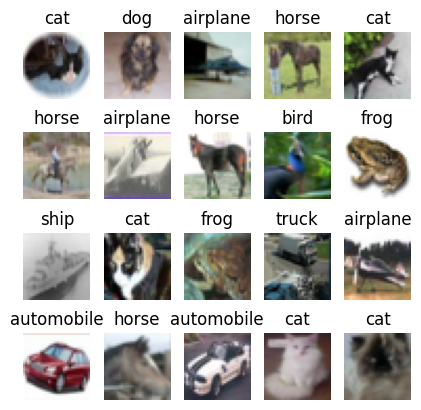

In [ ]:
# Visualize a random set of images and their the labels from the training split
figure = plt.figure(figsize=(5, 5))
cols, rows = 5, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.moveaxis(img.numpy(), 0, -1))

plt.show()

---

## Prepare DataLoaders for Training /Testing

- Will prepare **minibatches** with the given batch_size, less load on my device memory
- Enable multiprocessing to speed up data retrieval, use device GPU
- Reshuffle the data at every **epoch** won't be using seed

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64 # i'll start with a small batch size to save memory in my device

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_data,     batch_size=batch_size, shuffle=False)

# quick check the batch shapes
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64


---

# Part 1: Multilayer Perceptron (MLP)

## MLP Architecture

The MLP will have the following structure:
- **Input layer:** 3072 features (32×32×3 flattened image)
- **Hidden layer 1:** 512 neurons with ReLU activation
- **Hidden layer 2:** 256 neurons with ReLU activation
- **Output layer:** 10 neurons (one for each class)

In [ ]:
import torch
from torch import nn

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        # Network architecture for CIFAR-10 (32x32x3 = 3072 input features)
        self.network_layers = nn.Sequential(
            nn.Linear(32*32*3, 512),  # input layer: 3072 features → 512 neurons
            nn.ReLU(),
            nn.Linear(512, 256),      # hidden layer: 512 → 256 neurons. "Only 1 hidden layer for now"
            nn.ReLU(),
            nn.Linear(256, 10)        # output layer: 256 → 10 classes
        )

    def forward(self, x):
        x = self.flatten(x)
        output = self.network_layers(x)
        return output

In [ ]:
# Check the structure of our MLP
mlp_model = SimpleMLP()
print(mlp_model)

SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network_layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


## Define Training and Testing Functions

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Executes one full training epoch for the given model.

    Args:
        dataloader: The DataLoader providing batches of training data
        model: The neural network model to be trained
        loss_fn: The loss function used to compute the training loss
        optimizer: The optimizer responsible for updating the model's parameters

    Returns:
        tuple: (average training loss, training accuracy percentage)
    """
    size = len(dataloader.dataset)
    model.train()  # set the model to training mode

    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # Moving all data to device,  I will be using my GPU for computations
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()       # compute gradients
        optimizer.step()      # apply updates
        optimizer.zero_grad() # clear old gradients

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 200 == 0:
            loss_val, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

    correct /= size
    return train_loss / len(dataloader), 100 * correct


def test_loop(dataloader, model, loss_fn):
    """
    Evaluates the model's performance on a test dataset.

    Args:
        dataloader: The DataLoader providing batches of test data
        model: The trained neural network model to evaluate
        loss_fn: The loss function used to compute the evaluation loss

    Returns:
        tuple: (average test loss, test accuracy percentage)
    """
    model.eval()  # set the model to evaluation mode

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # No gradient computation during evaluation
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100 * correct

## Training the MLP Model

In [ ]:
import time

# initialize model, loss function, and optimizer
mlp_model = SimpleMLP()
mlp_model.to(device)

learning_rate = 1e-3
batch_size_val = 64
mlp_epochs = 100  # "I first started with 10", Training for 100 epochs to see where overfitting begins

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)

# create dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size_val, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size_val, shuffle=False)

# track metrics
mlp_train_losses = []
mlp_test_losses = []
mlp_train_accuracy = []
mlp_test_accuracy = []

start_time = time.time()

for t in range(mlp_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_acc = train_loop(train_dataloader, mlp_model, loss_fn, optimizer)
    avg_test_loss, test_acc = test_loop(test_dataloader, mlp_model, loss_fn)
    mlp_train_losses.append(avg_train_loss)
    mlp_test_losses.append(avg_test_loss)
    mlp_train_accuracy.append(train_acc)
    mlp_test_accuracy.append(test_acc)

print("Done!")
mlp_training_time = time.time() - start_time
print(f"Total training time: {mlp_training_time:.3f} sec")
print(f"{mlp_model.__class__.__name__} model has been trained!")

Epoch 1
-------------------------------
loss: 2.304607  [   64/50000]
loss: 2.304974  [12864/50000]
loss: 2.278545  [25664/50000]
loss: 2.282201  [38464/50000]
Test Error: 
 Accuracy: 16.4%, Avg loss: 2.273341 

Epoch 2
-------------------------------
loss: 2.270855  [   64/50000]
loss: 2.257485  [12864/50000]
loss: 2.237396  [25664/50000]
loss: 2.259943  [38464/50000]
Test Error: 
 Accuracy: 19.3%, Avg loss: 2.241612 

Epoch 3
-------------------------------
loss: 2.206511  [   64/50000]
loss: 2.257780  [12864/50000]
loss: 2.232821  [25664/50000]
loss: 2.214435  [38464/50000]
Test Error: 
 Accuracy: 21.6%, Avg loss: 2.197437 

Epoch 4
-------------------------------
loss: 2.171948  [   64/50000]
loss: 2.181744  [12864/50000]
loss: 2.154609  [25664/50000]
loss: 2.075264  [38464/50000]
Test Error: 
 Accuracy: 22.8%, Avg loss: 2.144863 

Epoch 5
-------------------------------
loss: 2.171180  [   64/50000]
loss: 2.149454  [12864/50000]
loss: 2.010485  [25664/50000]
loss: 2.129810  [38464

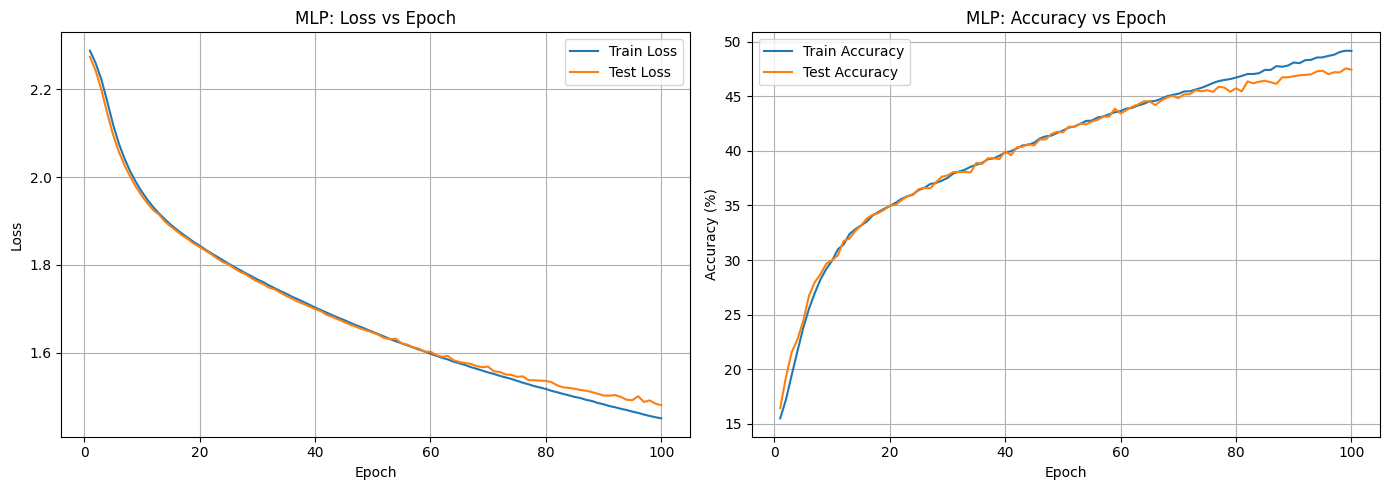


MLP Best Test Accuracy: 47.55% at Epoch 99


In [ ]:
# Visualize MLP training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(range(1, mlp_epochs+1), mlp_train_losses, label='Train Loss')
axes[0].plot(range(1, mlp_epochs+1), mlp_test_losses, label='Test Loss')
axes[0].set_title('MLP: Loss vs Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy curves
axes[1].plot(range(1, mlp_epochs+1), mlp_train_accuracy, label='Train Accuracy')
axes[1].plot(range(1, mlp_epochs+1), mlp_test_accuracy, label='Test Accuracy')
axes[1].set_title('MLP: Accuracy vs Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print best test accuracy and corresponding epoch
best_mlp_acc = max(mlp_test_accuracy)
best_mlp_epoch = mlp_test_accuracy.index(best_mlp_acc) + 1
print(f"\nMLP Best Test Accuracy: {best_mlp_acc:.2f}% at Epoch {best_mlp_epoch}")

I didnot get significant evidence of overfitting till 50 epochs. I plan to push it to 100 epochs to see if I get any evidence of overfitting.

After 70 ish epochs, I started to see some overfitting. I should stop now for more epochs.
I am still at low accuracy. May be I should try more hidden layers to get better accuracy.

---

# Part 2: Convolutional Neural Network (CNN)

## CNN Architecture

The CNN will have the following structure:
- **Conv layer 1:** 3 input channels → 32 output channels, 3×3 kernel
- **Conv layer 2:** 32 input channels → 64 output channels, 3×3 kernel
- **Flatten layer:** Flatten the feature maps
- **Fully Connected layer 1:** Dense layer with 128 neurons
- **Fully Connected layer 2:** Dense layer with 10 outputs (classes)

In [ ]:
import torch
from torch import nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Note: CIFAR-10 images are 32x32x3 (color images with 3 channels)

        # Convolutional layers for feature extraction
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),   # 3 input channels (RGB) → 32 output channels; output: [32, 30, 30]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),  # 32 → 64 channels; output: [64, 28, 28]
            nn.ReLU()
        )

        # Calculate the flattened size: 64 * 28 * 28 = 50176
        self.flatten = nn.Flatten()

        # Fully connected layers for classification
        self.linear_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 128),  # Dense layer
            nn.ReLU(),
            nn.Linear(128, 10)              # Output layer: 10 classes
        )

    def forward(self, x):
        output = self.conv_layers(x)
        output = self.flatten(output)
        output = self.linear_layers(output)
        return output

In [ ]:
# Check the structure of our CNN
cnn_model = SimpleCNN()
print(cnn_model)

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=50176, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Train the CNN Model

In [ ]:
# Initialize CNN model, loss function, and optimizer , Similar to MLP
cnn_model = SimpleCNN()
cnn_model.to(device)

learning_rate = 0.001
batch_size_val = 64
cnn_epochs = 50  #
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)

# Create dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size_val, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size_val, shuffle=False)

# Track metrics
cnn_train_losses = []
cnn_test_losses = []
cnn_train_accuracy = []
cnn_test_accuracy = []

start_time = time.time()

for t in range(cnn_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_acc = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_acc = test_loop(test_dataloader, cnn_model, loss_fn)
    cnn_train_losses.append(avg_train_loss)
    cnn_test_losses.append(avg_test_loss)
    cnn_train_accuracy.append(train_acc)
    cnn_test_accuracy.append(test_acc)

print("Done!")
cnn_training_time = time.time() - start_time
print(f"Total training time: {cnn_training_time:.3f} sec")
print(f"{cnn_model.__class__.__name__} model has been trained!")

Epoch 1
-------------------------------
loss: 2.303927  [   64/50000]
loss: 2.296162  [12864/50000]
loss: 2.279919  [25664/50000]
loss: 2.282942  [38464/50000]
Test Error: 
 Accuracy: 19.4%, Avg loss: 2.236278 

Epoch 2
-------------------------------
loss: 2.225484  [   64/50000]
loss: 2.196480  [12864/50000]
loss: 2.177086  [25664/50000]
loss: 2.243914  [38464/50000]
Test Error: 
 Accuracy: 24.8%, Avg loss: 2.102567 

Epoch 3
-------------------------------
loss: 2.179352  [   64/50000]
loss: 2.000131  [12864/50000]
loss: 2.034044  [25664/50000]
loss: 2.014421  [38464/50000]
Test Error: 
 Accuracy: 32.7%, Avg loss: 1.974002 

Epoch 4
-------------------------------
loss: 2.068717  [   64/50000]
loss: 1.912924  [12864/50000]
loss: 1.913558  [25664/50000]
loss: 1.997628  [38464/50000]
Test Error: 
 Accuracy: 33.1%, Avg loss: 1.907740 

Epoch 5
-------------------------------
loss: 1.993491  [   64/50000]
loss: 2.006978  [12864/50000]
loss: 1.953589  [25664/50000]
loss: 1.778399  [38464

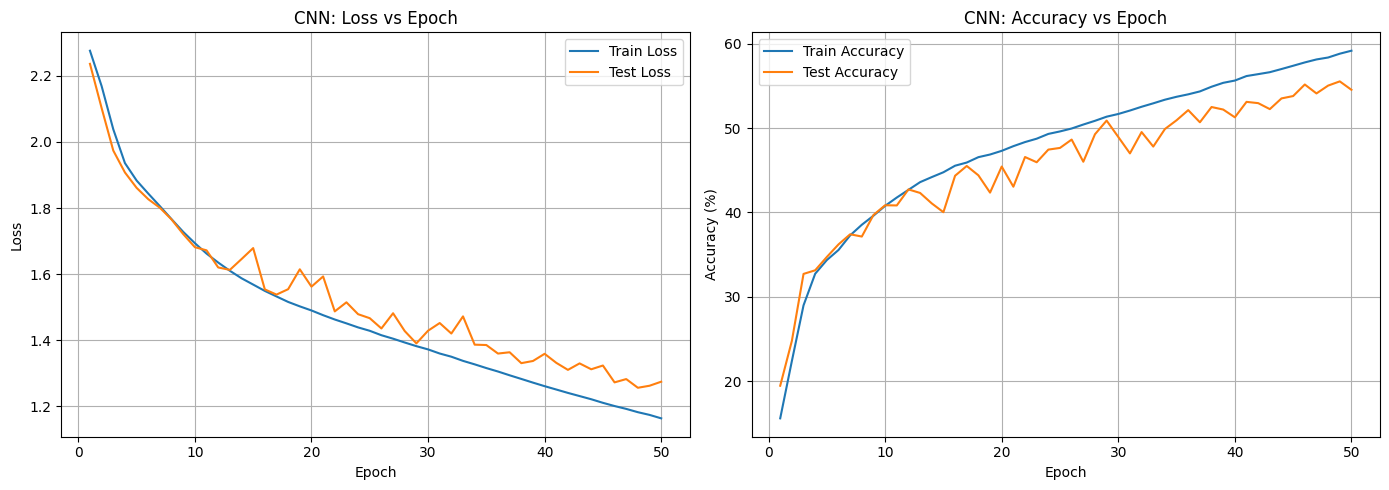


CNN Best Test Accuracy: 55.53% at Epoch 49


In [ ]:
# Visualize CNN training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(range(1, cnn_epochs+1), cnn_train_losses, label='Train Loss')
axes[0].plot(range(1, cnn_epochs+1), cnn_test_losses, label='Test Loss')
axes[0].set_title('CNN: Loss vs Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy curves
axes[1].plot(range(1, cnn_epochs+1), cnn_train_accuracy, label='Train Accuracy')
axes[1].plot(range(1, cnn_epochs+1), cnn_test_accuracy, label='Test Accuracy')
axes[1].set_title('CNN: Accuracy vs Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print best test accuracy and corresponding epoch
best_cnn_acc = max(cnn_test_accuracy)
best_cnn_epoch = cnn_test_accuracy.index(best_cnn_acc) + 1
print(f"\nCNN Best Test Accuracy: {best_cnn_acc:.2f}% at Epoch {best_cnn_epoch}")

So far for 20 epochs, I can see CNN is performing better than MLP with single hidden layer.
Also, I have not seen any significant overfitting in CNN at 20 epochs yet.
I will run it for 50 epochs and see if overfitting starts to occur.

Okay , right after 20 epochs , the CNN model started to overfit the training data.


---

## Model Comparison

Let's compare the performance of both models.

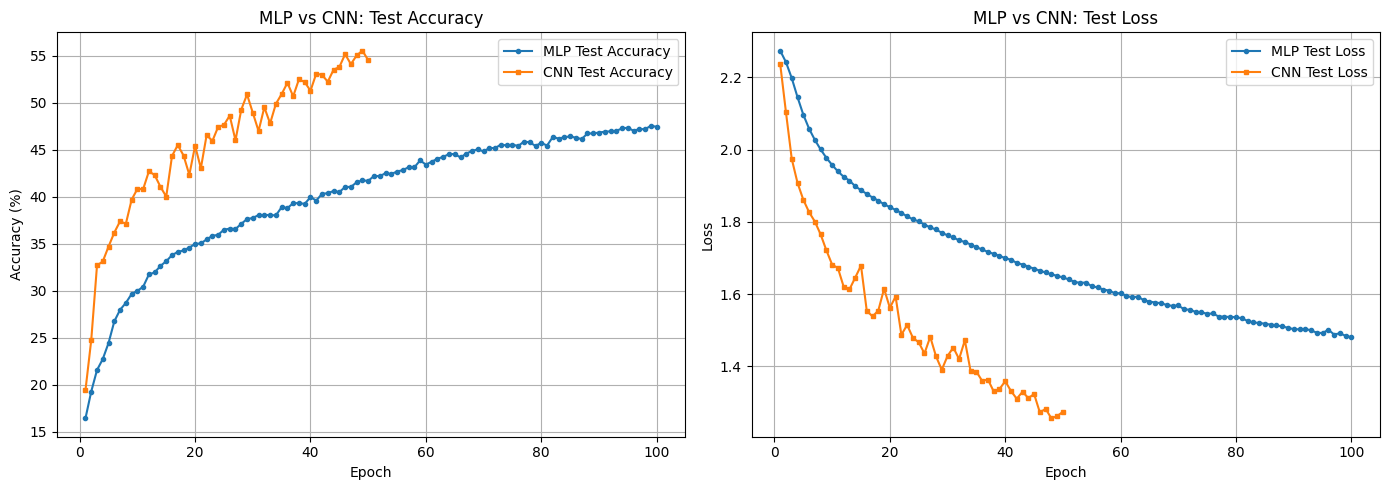


MODEL COMPARISON SUMMARY

MLP:
  - Best Test Accuracy: 47.55% at Epoch 99
  - Total Epochs Trained: 100
  - Training Time: 315.06 seconds

CNN:
  - Best Test Accuracy: 55.53% at Epoch 49
  - Total Epochs Trained: 50
  - Training Time: 222.60 seconds

 CNN outperforms MLP by 7.98%


In [ ]:
# Compare MLP and CNN performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test Accuracy Comparison
axes[0].plot(range(1, mlp_epochs+1), mlp_test_accuracy, label='MLP Test Accuracy', marker='o', markersize=3)
axes[0].plot(range(1, cnn_epochs+1), cnn_test_accuracy, label='CNN Test Accuracy', marker='s', markersize=3)
axes[0].set_title('MLP vs CNN: Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].legend()
axes[0].grid(True)

# Test Loss Comparison
axes[1].plot(range(1, mlp_epochs+1), mlp_test_losses, label='MLP Test Loss', marker='o', markersize=3)
axes[1].plot(range(1, cnn_epochs+1), cnn_test_losses, label='CNN Test Loss', marker='s', markersize=3)
axes[1].set_title('MLP vs CNN: Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*43)
print("MODEL COMPARISON SUMMARY")
print("="*43)
print(f"\nMLP:")
print(f"  - Best Test Accuracy: {best_mlp_acc:.2f}% at Epoch {best_mlp_epoch}")
print(f"  - Total Epochs Trained: {mlp_epochs}")
print(f"  - Training Time: {mlp_training_time:.2f} seconds")

print(f"\nCNN:")
print(f"  - Best Test Accuracy: {best_cnn_acc:.2f}% at Epoch {best_cnn_epoch}")
print(f"  - Total Epochs Trained: {cnn_epochs}")
print(f"  - Training Time: {cnn_training_time:.2f} seconds")

if best_cnn_acc > best_mlp_acc:
    print(f"\n CNN outperforms MLP by {best_cnn_acc - best_mlp_acc:.2f}%")
else:
    print(f"\n MLP outperforms CNN by {best_mlp_acc - best_cnn_acc:.2f}%")

## Visualize Some Predictions

Let's see how our trained CNN performs on some test images.

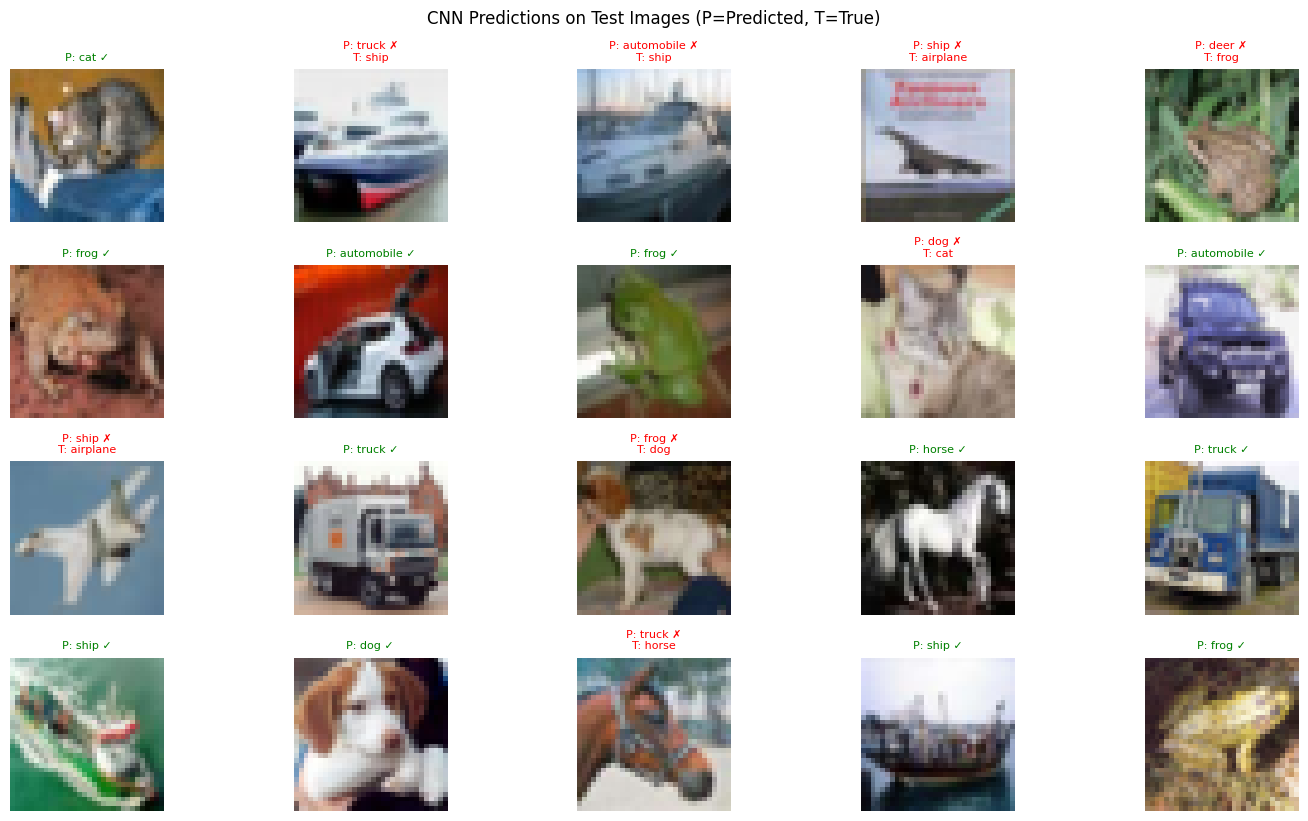

In [ ]:
# Visualize CNN predictions on test data
cnn_model.eval()

test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False)
test_inputs, test_labels = next(iter(test_dataloader))

test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

# Run forward pass
with torch.no_grad():
    logits = cnn_model(test_inputs)

preds = logits.argmax(dim=1)

# Plot predictions
images_shown = 20
plt.figure(figsize=(15, 8))
for i in range(images_shown):
    ax = plt.subplot(4, 5, i+1)
    img = test_inputs[i].cpu().numpy()
    img = np.moveaxis(img, 0, -1)  # Change from CxHxW to HxWxC
    plt.imshow(img)

    pred_label = labels_map[int(preds[i])]
    true_label = labels_map[int(test_labels[i])]

    if preds[i] == test_labels[i]:
        title = f"P: {pred_label} ✓"
        color = 'green'
    else:
        title = f"P: {pred_label} ✗\nT: {true_label}"
        color = 'red'
    ax.set_title(title, fontsize=8, color=color)
    ax.axis("off")

plt.tight_layout()
plt.suptitle('CNN Predictions on Test Images (P=Predicted, T=True)', y=1.02)
plt.show()

---

# OPTIONAL Part 3: Experiments with Deeper Networks
In this section, I will experiment with:
1. **More hidden layers ;6?** for MLP
I will use the same activation function as before, but with more hidden layers.


.

## Experiment 1: Deeper MLP with More Hidden Layers

Let's try an MLP with **6 hidden layers** instead , to see if adding more depth helps the model learn better representations.

In [ ]:
import torch
from torch import nn

# Experiment: Deeper MLP with 6 hidden layers using ReLU activation, might learn more complex patterns and hence increase accuracy
class DeepMLP_ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        # 6 hidden layers in total
        self.network_layers = nn.Sequential(
            nn.Linear(32*32*3, 1024),  # hidden layer 1: 3072 → 1024
            nn.ReLU(),

            nn.Linear(1024, 768),      # hidden layer 2: 1024 → 768
            nn.ReLU(),

            nn.Linear(768, 512),       # hidden layer 3: 768 → 512
            nn.ReLU(),

            nn.Linear(512, 256),       # hidden layer 4: 512 → 256
            nn.ReLU(),

            nn.Linear(256, 192),       # hidden layer 5: 256 → 192
            nn.ReLU(),

            nn.Linear(192, 128),       # hidden layer 6: 192 → 128
            nn.ReLU(),

            nn.Linear(128, 10)         # output layer
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.network_layers(x)


# Check the structure
deep_mlp_relu = DeepMLP_ReLU()
print("Deep MLP with ReLU (6 hidden layers):")
print(deep_mlp_relu)


Deep MLP with ReLU (6 hidden layers):
DeepMLP_ReLU(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network_layers): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=768, bias=True)
    (3): ReLU()
    (4): Linear(in_features=768, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=192, bias=True)
    (9): ReLU()
    (10): Linear(in_features=192, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# SAME AS BEFORE
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Executes one full training epoch for the given model.
    """
    size = len(dataloader.dataset)
    model.train()

    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Forward
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 200 == 0:
            loss_val, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

    correct /= size
    return train_loss / len(dataloader), 100 * correct


def test_loop(dataloader, model, loss_fn):
    """
    Evaluates the model on the test dataset.
    """
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    return test_loss, 100 * correct


In [ ]:
import time

# Initialize model, loss function, optimizer
mlp_model = DeepMLP_ReLU()
mlp_model.to(device)

learning_rate = .001
batch_size_val = 64
mlp_epochs = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)

# Dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size_val, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size_val, shuffle=False)

# Tracking metrics
mlp_train_losses = []
mlp_test_losses = []
mlp_train_accuracy = []
mlp_test_accuracy = []

start_time = time.time()

for t in range(mlp_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_acc = train_loop(train_dataloader, mlp_model, loss_fn, optimizer)
    avg_test_loss, test_acc = test_loop(test_dataloader, mlp_model, loss_fn)

    mlp_train_losses.append(avg_train_loss)
    mlp_test_losses.append(avg_test_loss)
    mlp_train_accuracy.append(train_acc)
    mlp_test_accuracy.append(test_acc)

print("Done!")
mlp_training_time = time.time() - start_time
print(f"Total training time: {mlp_training_time:.3f} sec")
print(f"{mlp_model.__class__.__name__} model has been trained!")


Epoch 1
-------------------------------
loss: 2.303347  [   64/50000]
loss: 2.305888  [12864/50000]
loss: 2.296948  [25664/50000]
loss: 2.297713  [38464/50000]
Test Error:
 Accuracy: 10.0%, Avg loss: 2.303872

Epoch 2
-------------------------------
loss: 2.298256  [   64/50000]
loss: 2.302285  [12864/50000]
loss: 2.308744  [25664/50000]
loss: 2.296902  [38464/50000]
Test Error:
 Accuracy: 10.0%, Avg loss: 2.303573

Epoch 3
-------------------------------
loss: 2.303236  [   64/50000]
loss: 2.298725  [12864/50000]
loss: 2.312745  [25664/50000]
loss: 2.304807  [38464/50000]
Test Error:
 Accuracy: 10.0%, Avg loss: 2.303326

Epoch 4
-------------------------------
loss: 2.306969  [   64/50000]
loss: 2.307953  [12864/50000]
loss: 2.299855  [25664/50000]
loss: 2.302797  [38464/50000]
Test Error:
 Accuracy: 10.0%, Avg loss: 2.303115

Epoch 5
-------------------------------
loss: 2.306709  [   64/50000]
loss: 2.308036  [12864/50000]
loss: 2.297078  [25664/50000]
loss: 2.305754  [38464/50000]


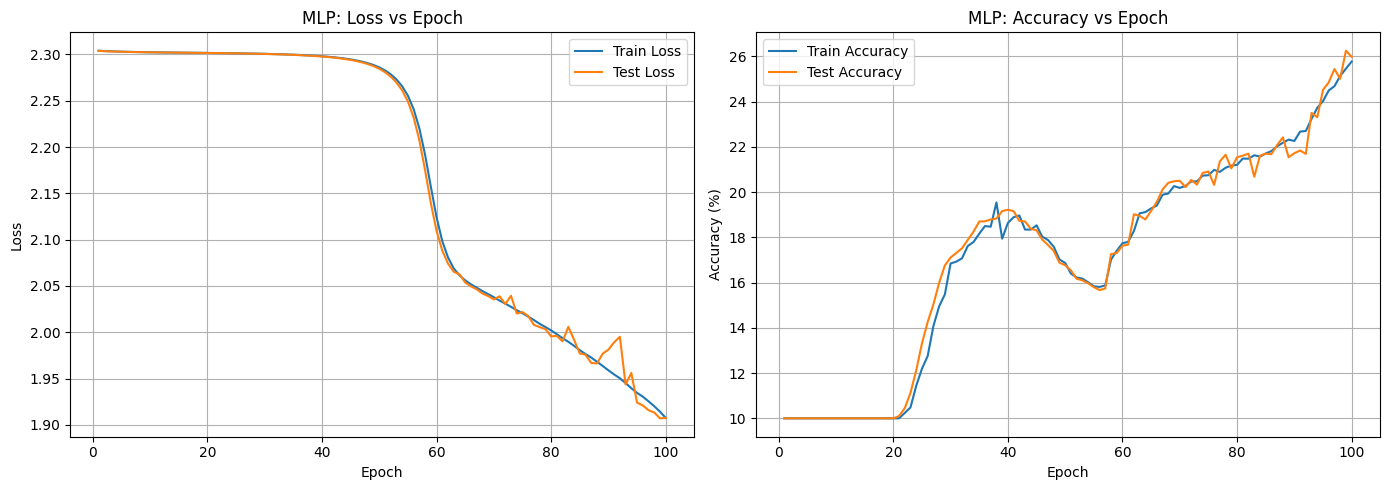


MLP with 6 hidden layers Best Test Accuracy: 26.25% at Epoch 99


In [ ]:
import matplotlib.pyplot as plt

# Visualize MLP training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(range(1, mlp_epochs+1), mlp_train_losses, label='Train Loss')
axes[0].plot(range(1, mlp_epochs+1), mlp_test_losses, label='Test Loss')
axes[0].set_title('MLP: Loss vs Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy curves
axes[1].plot(range(1, mlp_epochs+1), mlp_train_accuracy, label='Train Accuracy')
axes[1].plot(range(1, mlp_epochs+1), mlp_test_accuracy, label='Test Accuracy')
axes[1].set_title('MLP: Accuracy vs Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Best test accuracy
best_mlp_acc = max(mlp_test_accuracy)
best_mlp_epoch = mlp_test_accuracy.index(best_mlp_acc) + 1
print(f"\nMLP with 6 hidden layers Best Test Accuracy: {best_mlp_acc:.2f}% at Epoch {best_mlp_epoch}")


Adding more hidden layers to the MLP actually decreased the accuracy. I was getting MLP Best Test Accuracy: 47.89% at Epoch 100 with just one hidden layer.
compared to: MLP with 6 hidden layers Best Test Accuracy: 31.79% at Epoch 98


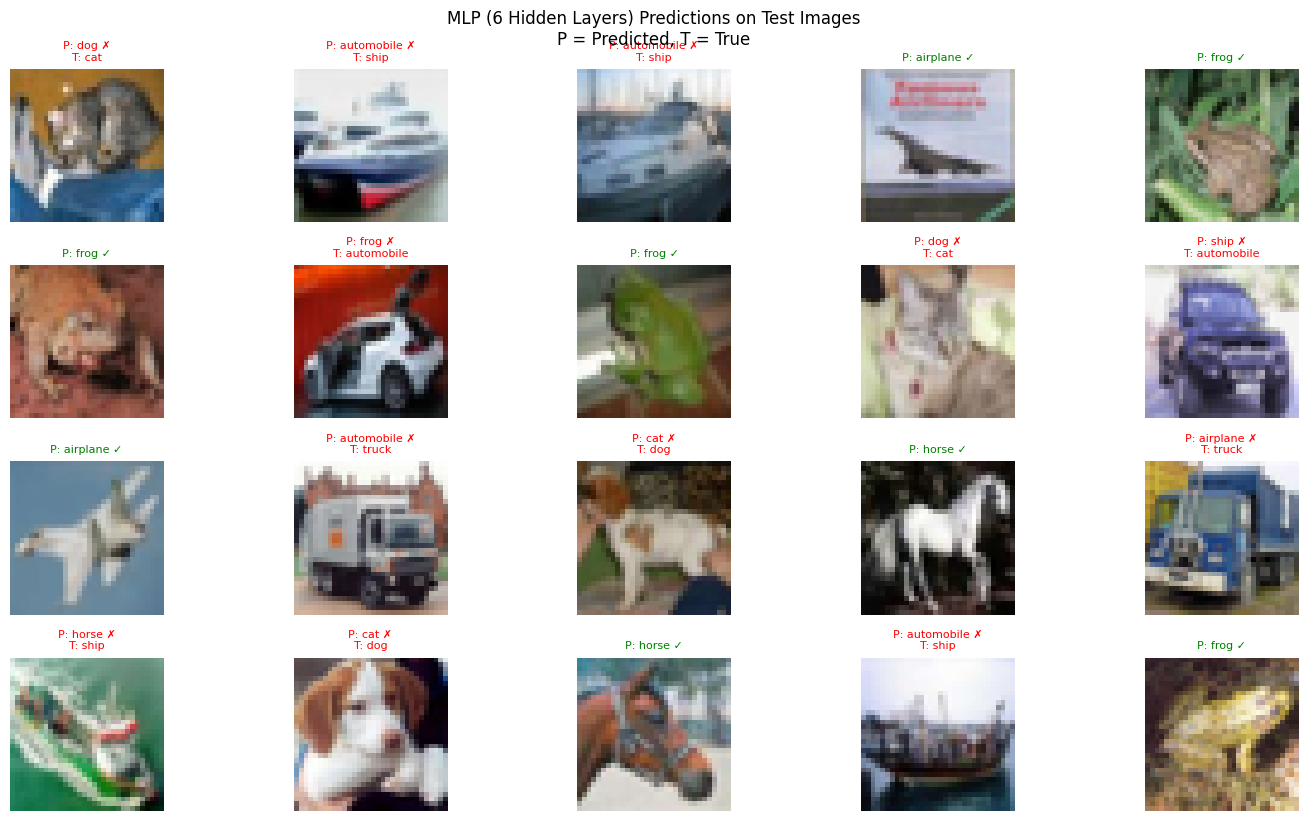

In [ ]:
# Visualize MLP predictions on test data

mlp_model.eval()

test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False)
test_inputs, test_labels = next(iter(test_dataloader))

test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

# Run forward pass
with torch.no_grad():
    # Use the trained model
    logits = mlp_model(test_inputs)

preds = logits.argmax(dim=1)

# Plot predictions
images_shown = 20
plt.figure(figsize=(15, 8))
for i in range(images_shown):
    ax = plt.subplot(4, 5, i+1)

    img = test_inputs[i].cpu().numpy()
    img = np.moveaxis(img, 0, -1)  # CxHxW -> HxWxC

    plt.imshow(img)

    pred_label = labels_map[int(preds[i])]
    true_label = labels_map[int(test_labels[i])]

    if preds[i] == test_labels[i]:
        title = f"P: {pred_label} ✓"
        color = 'green'
    else:
        title = f"P: {pred_label} ✗\nT: {true_label}"
        color = 'red'

    ax.set_title(title, fontsize=8, color=color)
    ax.axis("off")

plt.tight_layout()
plt.suptitle('MLP (6 Hidden Layers) Predictions on Test Images\nP = Predicted, T = True', y=1.02)
plt.show()

#Answering some Questions
1. Describe the process you used to tune the models. How many epochs of training have been utilized for the MLP? How many epochs of training have been utilized for CNN?

For this experiment I used one hidden layer and also  more hidden layers (6) for MLP . I also played around with number of epochs used. I sticked with ReLU activation function only. I could have tried some other like TanH,... etc. but I think ReLU would be standard choice.

2. How accurate can you make your MLP predictor? How accurate can you make your CNN predictor? At which epoch do you anticipate achieving the best results, respectively, for MLP and CNN?


Single Hidden layer
MLP Best Test Accuracy: 47.55% at Epoch 99

After 70 ish epochs, I started to see some overfitting


CNN Best Test Accuracy: 55.53% at Epoch 49

Right after 20 epochs , the CNN model started to overfit the training data.



MLP:
  - Best Test Accuracy: 47.55% at Epoch 99
  - Total Epochs Trained: 100
  - Training Time: 315.06 seconds

CNN:
  - Best Test Accuracy: 55.53% at Epoch 49
  - Total Epochs Trained: 50
  - Training Time: 222.60 seconds

 CNN outperforms MLP by 7.98%


 MLP with 6 hidden layers Best Test Accuracy: 31.79% at Epoch 98


 3. What configuration of your network (MLP or CNN) proved to be more accurate? Why do you think this is the case?


 In my experiments, CNN performed noticeably better than all the MLP versions. The main reason is that CNNs are designed specifically for common characteristics in image   data, so they can pick up patterns like textures, and shapes and edges  much more effectively. MLPs flatten the image and lose that spatial structure, which made it harder for  to learn meaningful features of the image data . I also noticed that adding more hidden layers to the MLP actually made its accuracy worse, probably because it overfit and became harder to train or even might be flattened?. Overall, the CNN generalized better (not the best of this case ) and handled the CIFAR-10 images more (comparatively)naturally, which is why it ended up being the more accurate model.




#**CHASE FOR BETTER ACCURACY**:

---



In [ ]:
pip install fastai


In [ ]:
from fastai.vision.all import *

In [ ]:
#path config
path = untar_data(URLs.CIFAR)
path.ls()

(#3) [Path('/Users/sagar/.fastai/data/cifar10/test'),Path('/Users/sagar/.fastai/data/cifar10/labels.txt'),Path('/Users/sagar/.fastai/data/cifar10/train')]

In [ ]:
# the directory structure
(path/'train').ls()

(#10) [Path('/Users/sagar/.fastai/data/cifar10/train/cat'),Path('/Users/sagar/.fastai/data/cifar10/train/dog'),Path('/Users/sagar/.fastai/data/cifar10/train/truck'),Path('/Users/sagar/.fastai/data/cifar10/train/bird'),Path('/Users/sagar/.fastai/data/cifar10/train/airplane'),Path('/Users/sagar/.fastai/data/cifar10/train/ship'),Path('/Users/sagar/.fastai/data/cifar10/train/frog'),Path('/Users/sagar/.fastai/data/cifar10/train/horse'),Path('/Users/sagar/.fastai/data/cifar10/train/deer'),Path('/Users/sagar/.fastai/data/cifar10/train/automobile')]

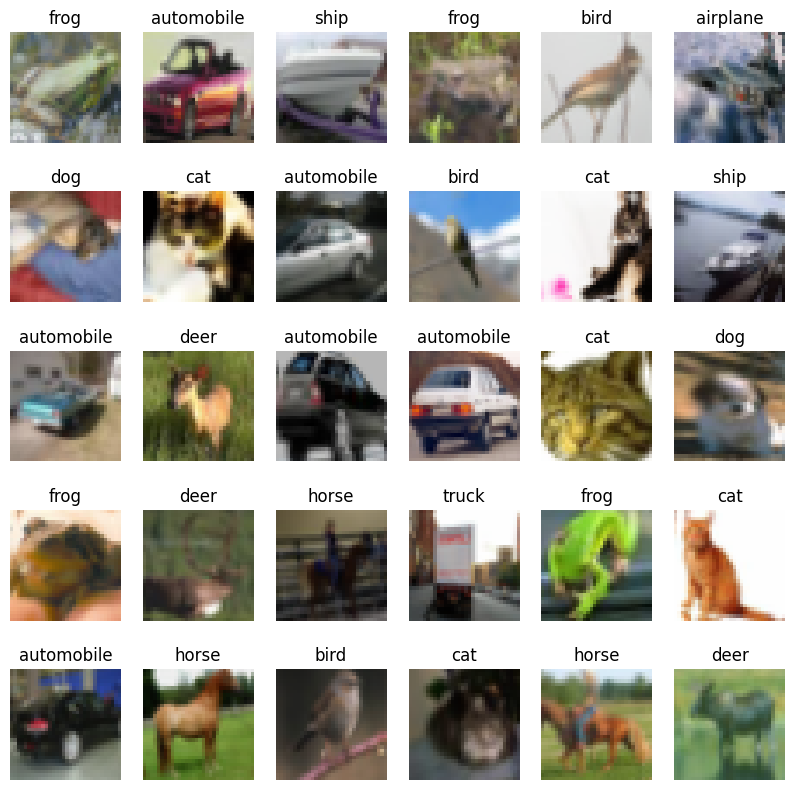

In [ ]:
# code refrence : https://docs.fast.ai/tutorial.datablock.html
cifar_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    get_y=parent_label,
    batch_tfms=aug_transforms()
)


dls = cifar_db.dataloaders(path, bs=64)

# diplay a bit of the data
dls.show_batch(max_n=30, figsize=(10, 10))


## Time to train

epoch,train_loss,valid_loss,accuracy,time
0,1.700387,1.507875,0.475400,00:33


epoch,train_loss,valid_loss,accuracy,time
0,1.008912,0.879505,0.694600,00:38
1,0.763967,0.701580,0.760900,00:37
2,0.653206,0.590508,0.796700,00:37
3,0.554022,0.575318,0.802700,00:37


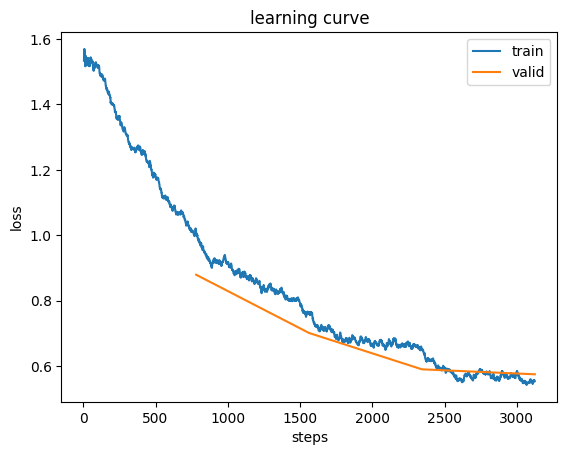

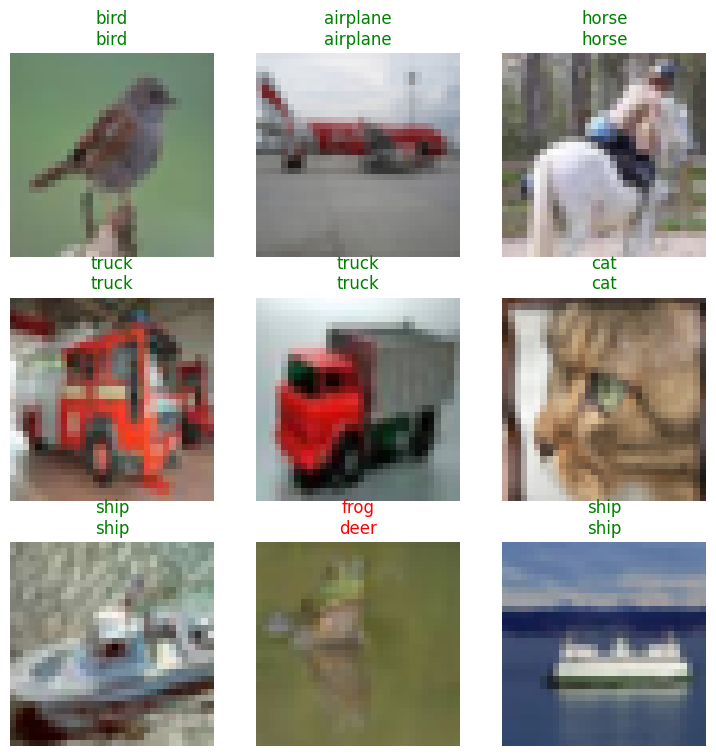

In [ ]:

learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(4) # will go for 4 epochs

learn.recorder.plot_loss() #BUILT IN FUNCTION

learn.show_results() #shows result




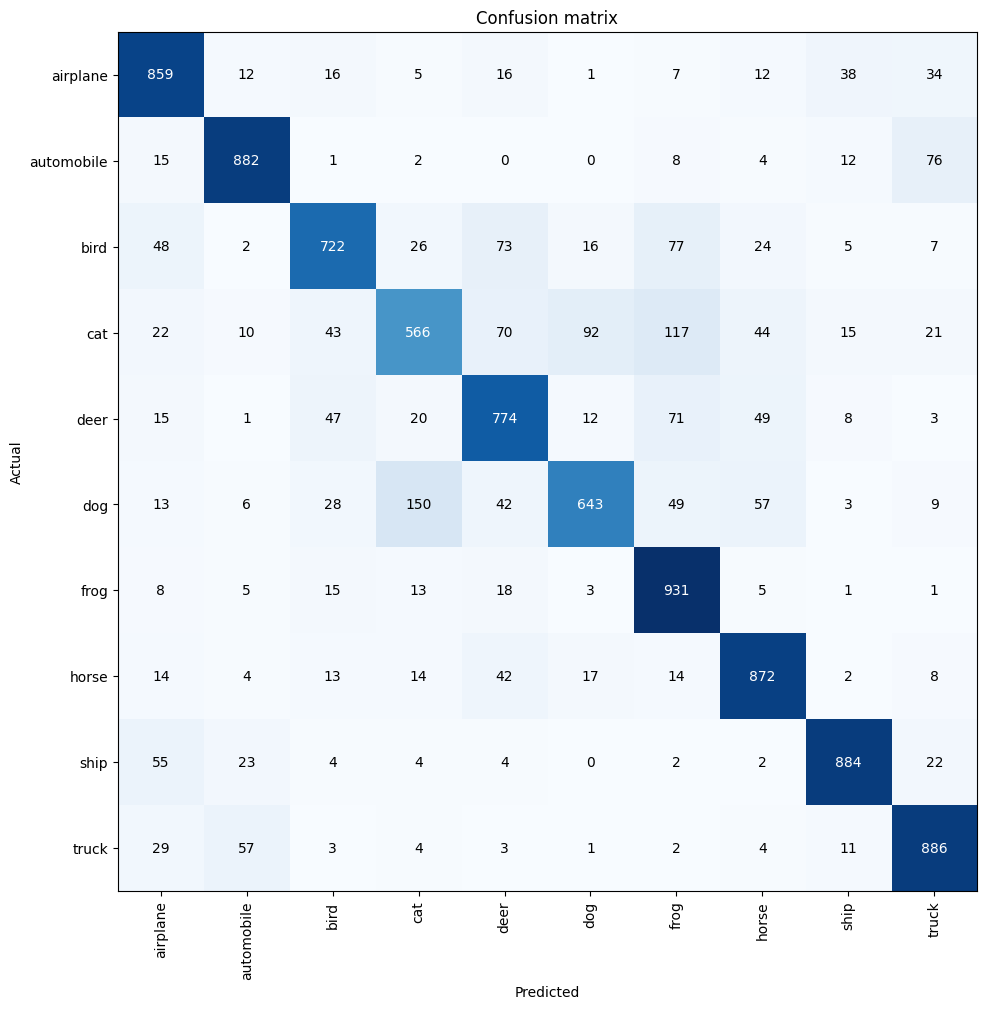

In [ ]:
# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

I am still getting around 80% accuracy. I am not sure what I am doing wrong. I was hoping to get above 90% accuracy after Fast.ai. May be more epochs? But there will be possibility of overfitting.

I think what could be the problem is, size of image .

https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html
Copied:  The inference transforms are available at ResNet34_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

I will manually resize the image to 224x224 then train again.

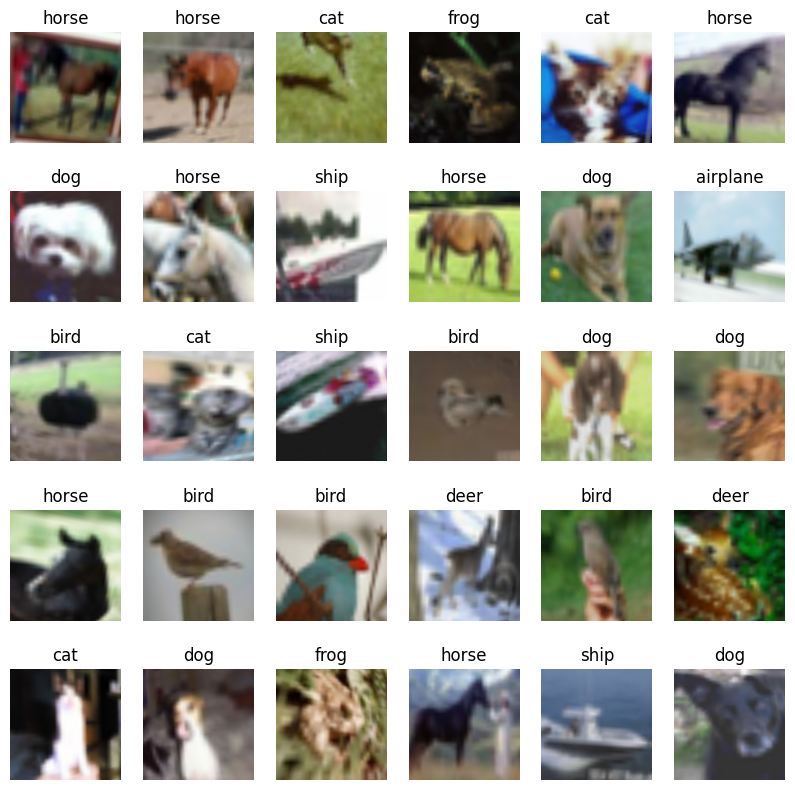

In [ ]:
# code refrence : https://docs.fast.ai/tutorial.datablock.html
cifar_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    get_y=parent_label,
    item_tfms=Resize(224), # manual resize images to 224x224
    batch_tfms=aug_transforms()
)


dls = cifar_db.dataloaders(path, bs=64)

# diplay a bit of the data
dls.show_batch(max_n=30, figsize=(10, 10))


epoch,train_loss,valid_loss,accuracy,time
0,0.608710,0.367945,0.875000,02:33


epoch,train_loss,valid_loss,accuracy,time
0,0.268225,0.200453,0.928900,03:28
1,0.200648,0.161221,0.944100,03:30
2,0.109773,0.114465,0.960600,03:31
3,0.063593,0.108664,0.963300,03:30


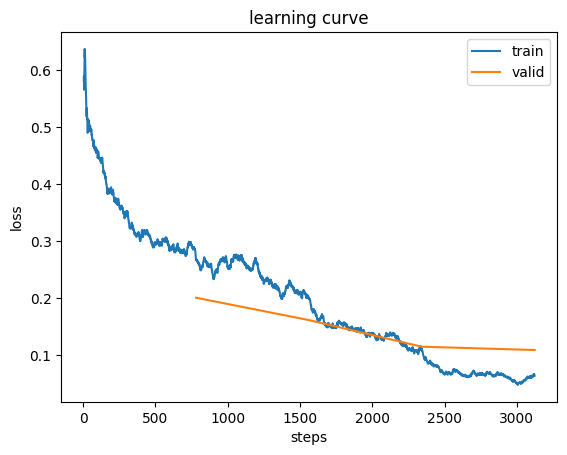

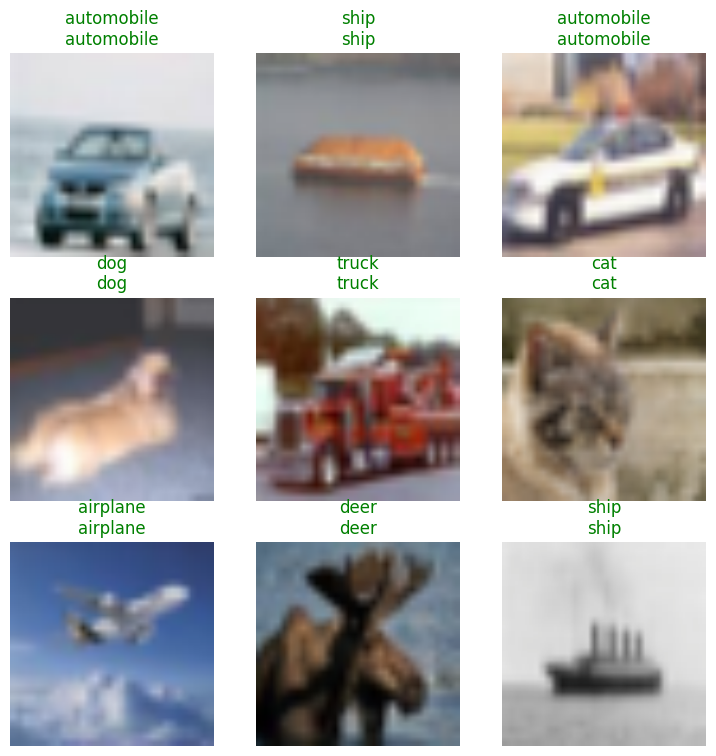

In [ ]:
#train the model again

learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(4) # will go for 4 epochs

learn.recorder.plot_loss() # BUILT IN FUNCTION

learn.show_results() #shows result




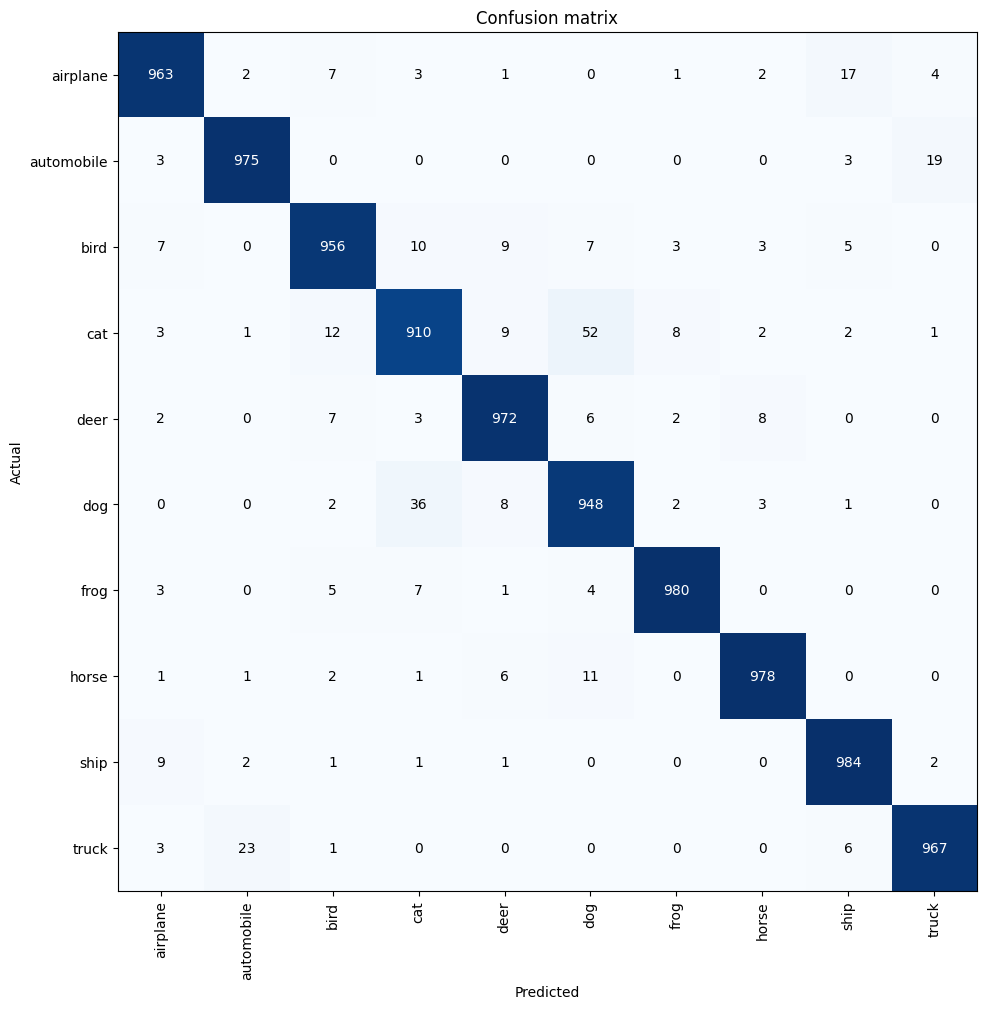

In [ ]:
# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

#What Happened here ? IN NUTSHELL.

With fast.ai, I  built an image classification kinda pipeline using a DataBlock that specified images as inputs, category labels, a folder based train/test split, data from my folder , label extraction from parent directories, and resizing images to 224×224 (manually for second step). fast.ai then handled all the heavy lifting automatically,  it created the underlying PyTorch Datasets and DataLoaders, loaded and batched images, normalized pixel values, applied transforms, and moved everything to the GPU. During training, fast.ai also managed the full training loop , including forward passes, back propagation, all kinds of  optimization, mixed precision speedups, and metrics which allowed  me  to train a working CIFAR-10 classifier with minimal code. This all happened in just few lines of code and the result I got was amazing .

#Closing Remarks
It was overall quite interesting and fun to go  through this all the process. Sometime something you expect won't exactly happen in the same exact way, as for example , I thought adding more hidden layer will improve accuracy , but got reverse result, ( I suspect if its loosing important traits and feature of image specially while flattening process). But anyway , This should be all for this Notebook.

##Honestly, We used plenty of our own NEURONS just to train these NEURONS